In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat


ctfile1 = "ciphertext-00112233445566778899aabbccddeeff.txt"
ctfile2 = "ciphertext-unknown_key.txt"
ptfile1 = "plaintext-00112233445566778899aabbccddeeff.txt"
ptfile2 = "plaintext-unknown_key.txt"
trfile1 = "traces-00112233445566778899aabbccddeeff.bin"
trfile1 = "traces-00112233445566778899aabbccddeeff.npy"
trfile2 = "traces-unknown_key.bin"
trfile2 = "traces-unknown_key.npy"

Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

In [2]:
#################################################
#                                               #
#                                               #
#        C O D E   S T A R T S   H E R E        #
#                                               #
#                                               #
#################################################
from Crypto.Cipher import AES

tohex = np.vectorize(lambda x: int(x, 16))

def myin(filename):
    with open(filename, 'r') as f:
        data = f.readlines()[:-1]
    return tohex(np.array([line[:-2].split(" ") for line in data]))    

def myload(filename):
    return np.load(filename)

from functools import lru_cache

@lru_cache(maxsize=1000)
def hamming_weight(number):
    return bin(number).count('1')

@lru_cache(maxsize=70_000) # Hemming weight sbox output
def intermediate_value(byte, key):
    return hamming_weight(Sbox[byte^key])

@lru_cache(maxsize=70_000) # Hemming weight of sbox input
def intermediate_value2(byte, key):
    return hamming_weight(byte^key)

@lru_cache(maxsize=70_000)
def intermediate_value3(byte, key): # Hemming distance betweeing sbox output and input
    #return intermediate_value2(byte, key)^intermediate_value3(byte, key)
    return hamming_weight(Sbox[byte^key]^(byte^key))

def convert_li_to_key(li):
    # Convert each number to its corresponding hexadecimal representation
    hex_list = [hex(num)[2:].zfill(2) for num in li]

    # Join the hexadecimal representations together
    final_hex = "".join(hex_list)

    # Add "0x" prefix to the final_hex to represent it as a hexadecimal number
    final_hex_with_prefix = "0x" + final_hex
    return final_hex_with_prefix

def mycorr(x, y):
    return np.corrcoef(x, y)[0, 1]

def translate_hex_string(hex_string):
    byte_string = bytes.fromhex(hex_string.replace(" ", ""))
    return byte_string

def test_key_known(key):
    key = translate_hex_string(key)
    with open(ptfile1, 'r') as f:
        data = translate_hex_string(f.readline().strip())
    with open(ctfile1, 'r') as f:
        result = translate_hex_string(f.readline().strip())
    cipher = AES.new(key, AES.MODE_ECB)
    ciphertext = cipher.encrypt(data)
    return ciphertext == result

def test_key(key):
    key = translate_hex_string(key)
    with open(ptfile2, 'r') as f:
        data = translate_hex_string(f.readline().strip())
    with open(ctfile2, 'r') as f:
        result = translate_hex_string(f.readline().strip())
    cipher = AES.new(key, AES.MODE_ECB)
    ciphertext = cipher.encrypt(data)
    return ciphertext == result

from numpy.matlib import repmat

def mycorr2(x,y):
    xr,xc = x.shape
    yr,yc = y.shape
    assert xr==yr, "Matrix row count mismatch"     

    x = x - x.mean(0)
    y = y - y.mean(0)
    C = x.T.dot(y)
    xsq = np.atleast_2d(np.sqrt(np.sum(x**2, 0)))
    ysq = np.atleast_2d(np.sqrt(np.sum(y**2, 0)))
    C = np.divide(C, repmat(xsq.T, 1, yc))
    C = np.divide(C, repmat(ysq, xc, 1))
    return C

def cpa(start, search, test, tr, pt, intermediate):
    traces = myload(tr)
    plaintexts = myin(pt)

    num_traces = len(traces)
    num_samples_per_trace = len(traces[0])
    num_key_guesses = 256

    # Placeholder for correlation coefficients
    cc_max = np.zeros((16, num_key_guesses))
    best_key_guess = np.zeros(16, dtype=int)

    # Trace where max is, helps narrow things down
    trace_max = np.zeros((16, num_key_guesses), dtype=int)

    search_length = search
    
    prev_trace = 0
    for byte_index in range(16):
        hypothetical_power_consumptions = np.zeros((num_traces, num_key_guesses))

        for key_guess in range(num_key_guesses):
            # Calculate hypothetical power consumption
            for trace_index in range(num_traces):
                hypothetical_power_consumptions[trace_index, key_guess] = intermediate(plaintexts[trace_index][byte_index], key_guess)

        for sample_index in range(start, start+search_length):
            actual_power = traces[:, sample_index:sample_index+1]  # Make actual_power a 2D matrix with a single column
            cc_matrix = mycorr2(hypothetical_power_consumptions, actual_power)

            # Update the best correlation and key guess if necessary
            for key_guess in range(num_key_guesses):
                cc = cc_matrix[key_guess, 0]  # Since actual_power has only one column, use 0 as the column index
                if cc > cc_max[byte_index][key_guess]:
                    cc_max[byte_index][key_guess] = cc
                    trace_max[byte_index][key_guess] = sample_index

        # Find the best key guess for this byte index
        best_key = np.argmax(cc_max[byte_index])
        best_key_guess[byte_index] = best_key
        print(f"{byte_index}: {best_key:#04x}")
        print("Trace at:", trace_max[byte_index][best_key])
        if byte_index > 0:
            print("Distance to previous trace:", trace_max[byte_index][best_key]-prev_trace)
        prev_trace = trace_max[byte_index][best_key]
        start = trace_max[byte_index][best_key] + 250  # Adjust start for the next byte index
        search_length = 250  # Adjust search_length as needed

    # Print the best key guess for each byte
    print("Best key guess per byte:", best_key_guess)
    final_key = convert_li_to_key(best_key_guess)
    print("Key:", final_key)
    print("Test:", test(final_key[2:]))
    return final_key

traces (200, 370000)
plaintexts (200, 16)


<IPython.core.display.Javascript object>


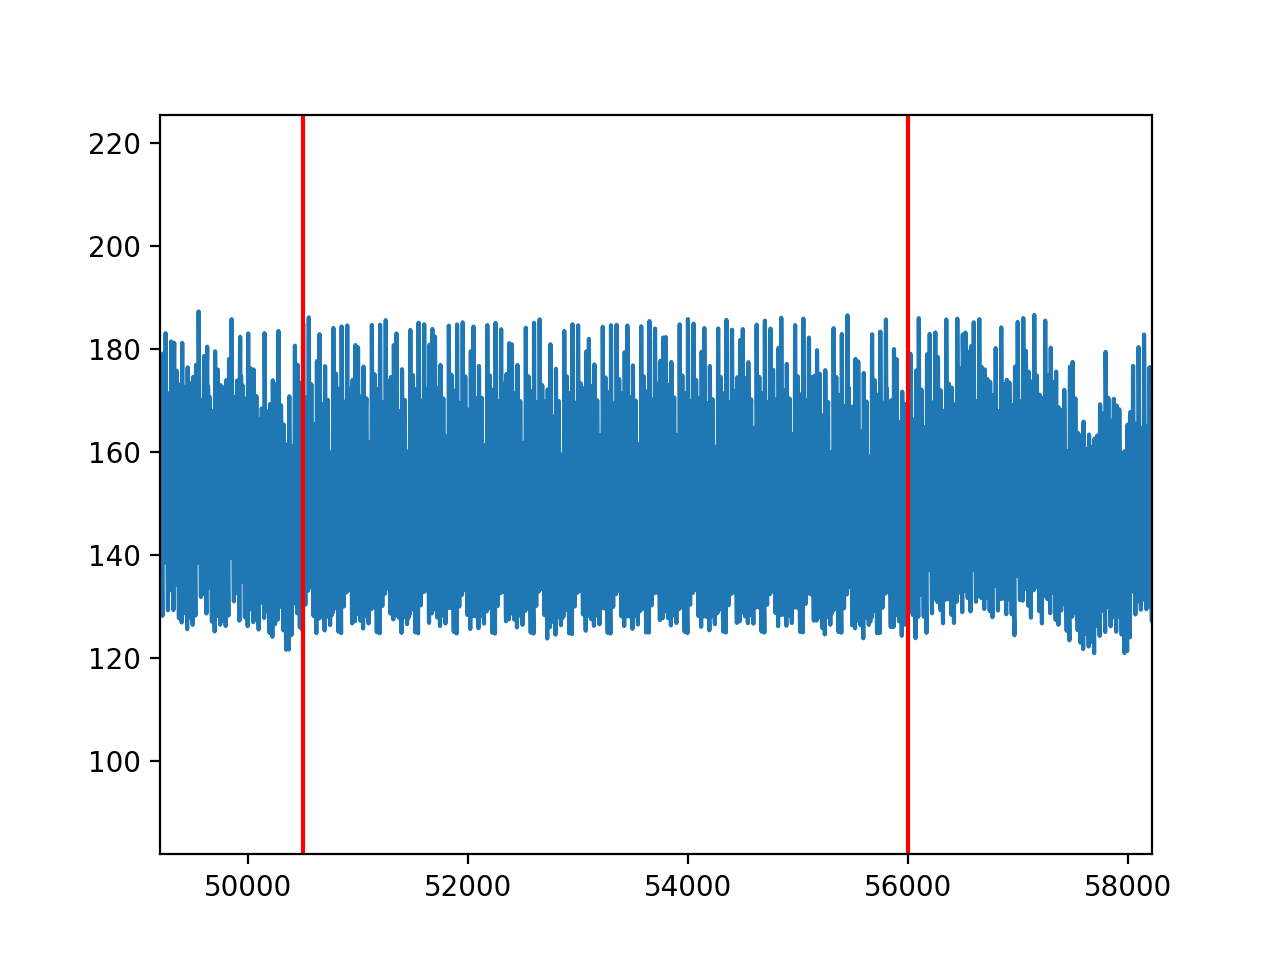

In [3]:
traces = myload(trfile1)
plaintexts = myin(ptfile1)

#Use this to check that you loaded the files correctly
print("traces", traces.shape)
print("plaintexts", plaintexts.shape)

start = 50_500
stop = 56_000


%matplotlib notebook
plt.figure()
column_means = np.mean(traces[:, :], axis=0)
plt.plot(column_means)
plt.axvline(start, color="r")
plt.axvline(stop, color="r")

In [4]:
cpa(50_500, 1000, test_key_known, trfile1, ptfile1, intermediate_value)

0: 0x00
Trace at: 50631
1: 0x11
Trace at: 50981
Distance to previous trace: 350
2: 0x22
Trace at: 51281
Distance to previous trace: 300
3: 0x33
Trace at: 51681
Distance to previous trace: 400
4: 0x44
Trace at: 52031
Distance to previous trace: 350
5: 0x55
Trace at: 52381
Distance to previous trace: 350
6: 0x66
Trace at: 52731
Distance to previous trace: 350
7: 0x77
Trace at: 53031
Distance to previous trace: 300
8: 0x88
Trace at: 53425
Distance to previous trace: 394
9: 0x99
Trace at: 53781
Distance to previous trace: 356
10: 0xaa
Trace at: 54126
Distance to previous trace: 345
11: 0xbb
Trace at: 54481
Distance to previous trace: 355
12: 0xcc
Trace at: 54775
Distance to previous trace: 294
13: 0xdd
Trace at: 55181
Distance to previous trace: 406
14: 0xee
Trace at: 55531
Distance to previous trace: 350
15: 0xff
Trace at: 55881
Distance to previous trace: 350
Best key guess per byte: [  0  17  34  51  68  85 102 119 136 153 170 187 204 221 238 255]
Key: 0x00112233445566778899aabbccddeeff

'0x00112233445566778899aabbccddeeff'

In [5]:
cpa(50_500, 1000, test_key_known, trfile1, ptfile1, intermediate_value3)

0: 0x00
Trace at: 50540
1: 0x11
Trace at: 50890
Distance to previous trace: 350
2: 0x22
Trace at: 51240
Distance to previous trace: 350
3: 0x33
Trace at: 51590
Distance to previous trace: 350
4: 0x44
Trace at: 51940
Distance to previous trace: 350
5: 0x55
Trace at: 52290
Distance to previous trace: 350
6: 0x66
Trace at: 52640
Distance to previous trace: 350
7: 0x77
Trace at: 52990
Distance to previous trace: 350
8: 0x88
Trace at: 53340
Distance to previous trace: 350
9: 0x99
Trace at: 53690
Distance to previous trace: 350
10: 0xaa
Trace at: 54040
Distance to previous trace: 350
11: 0xbb
Trace at: 54390
Distance to previous trace: 350
12: 0xcc
Trace at: 54740
Distance to previous trace: 350
13: 0xdd
Trace at: 55090
Distance to previous trace: 350
14: 0xee
Trace at: 55440
Distance to previous trace: 350
15: 0xff
Trace at: 55790
Distance to previous trace: 350
Best key guess per byte: [  0  17  34  51  68  85 102 119 136 153 170 187 204 221 238 255]
Key: 0x00112233445566778899aabbccddeeff

'0x00112233445566778899aabbccddeeff'

traces (149, 550000)
plaintexts (149, 16)


<IPython.core.display.Javascript object>


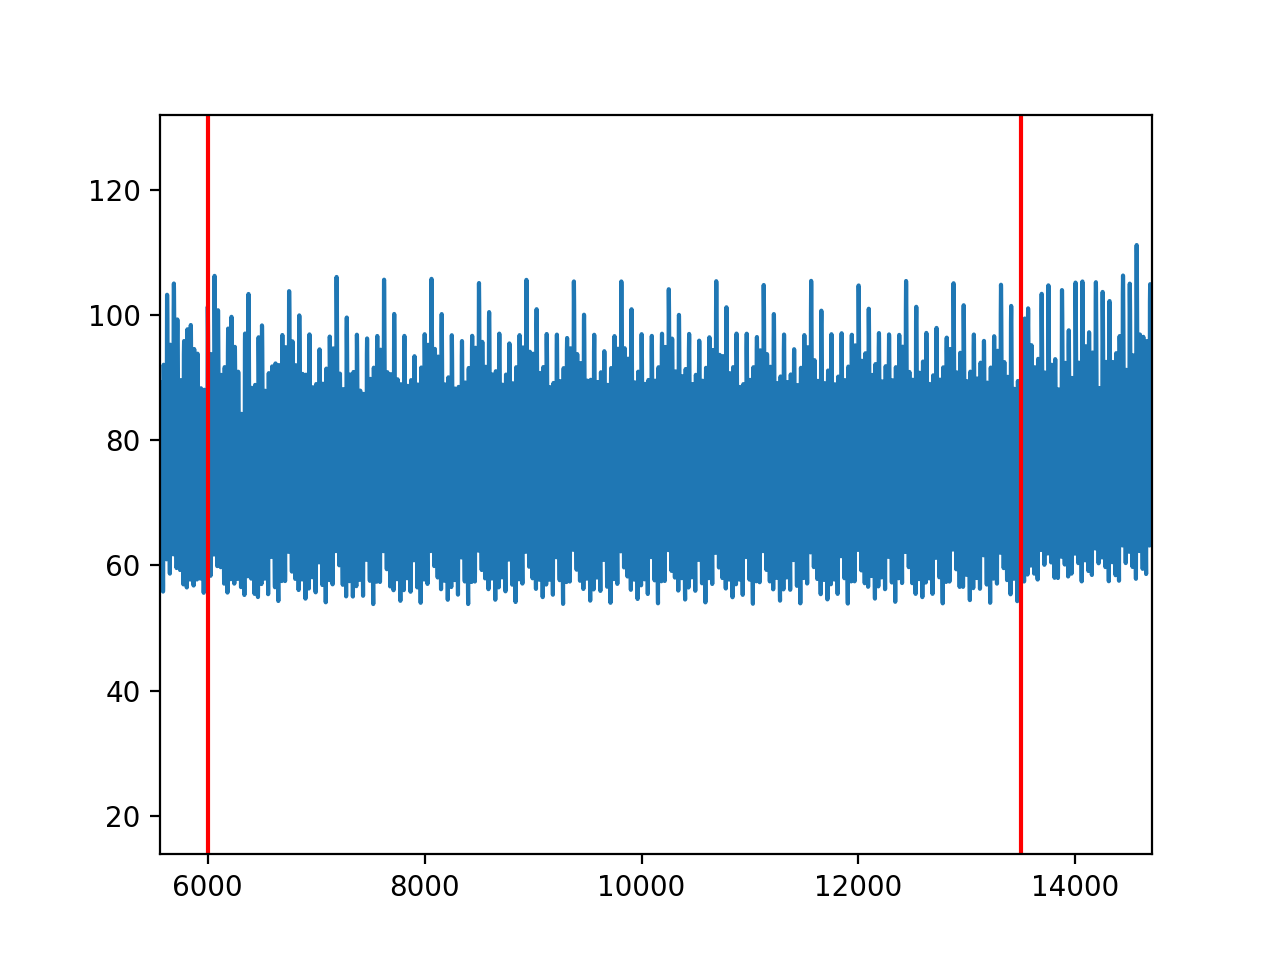

In [12]:
traces = myload(trfile2)
plaintexts = myin(ptfile2)

#Use this to check that you loaded the files correctly
print("traces", traces.shape)
print("plaintexts", plaintexts.shape)

start = 6000
stop = 13_500


%matplotlib notebook
plt.figure()
column_means = np.mean(traces[:, :], axis=0)
plt.plot(column_means)
plt.axvline(start, color="r")
plt.axvline(stop, color="r")

In [7]:
final_key1 = cpa(6000, 2000, test_key, trfile2, ptfile2, intermediate_value)
print(final_key1)

0: 0x05
Trace at: 7235
1: 0x4c
Trace at: 7489
Distance to previous trace: 254
2: 0xf4
Trace at: 7878
Distance to previous trace: 389
3: 0xa3
Trace at: 8329
Distance to previous trace: 451
4: 0xf4
Trace at: 8598
Distance to previous trace: 269
5: 0xd6
Trace at: 8887
Distance to previous trace: 289
6: 0xf8
Trace at: 9346
Distance to previous trace: 459
7: 0x1c
Trace at: 9752
Distance to previous trace: 406
8: 0xd1
Trace at: 10187
Distance to previous trace: 435
9: 0xd1
Trace at: 10531
Distance to previous trace: 344
10: 0x3e
Trace at: 10918
Distance to previous trace: 387
11: 0x0e
Trace at: 11202
Distance to previous trace: 284
12: 0xda
Trace at: 11517
Distance to previous trace: 315
13: 0x71
Trace at: 11866
Distance to previous trace: 349
14: 0xa9
Trace at: 12145
Distance to previous trace: 279
15: 0x55
Trace at: 12557
Distance to previous trace: 412
Best key guess per byte: [  5  76 244 163 244 214 248  28 209 209  62  14 218 113 169  85]
Key: 0x054cf4a3f4d6f81cd1d13e0eda71a955
Test: F

In [8]:
final_key2 = cpa(6000, 2000, test_key, trfile2, ptfile2, intermediate_value2)
print(final_key2)

0: 0x85
Trace at: 6689
1: 0xde
Trace at: 7126
Distance to previous trace: 437
2: 0xad
Trace at: 7564
Distance to previous trace: 438
3: 0xbe
Trace at: 8002
Distance to previous trace: 438
4: 0xef
Trace at: 8439
Distance to previous trace: 437
5: 0x42
Trace at: 8876
Distance to previous trace: 437
6: 0x00
Trace at: 9313
Distance to previous trace: 437
7: 0x68
Trace at: 9751
Distance to previous trace: 438
8: 0x61
Trace at: 10189
Distance to previous trace: 438
9: 0x63
Trace at: 10626
Distance to previous trace: 437
10: 0x6b
Trace at: 11063
Distance to previous trace: 437
11: 0x65
Trace at: 11501
Distance to previous trace: 438
12: 0x64
Trace at: 11939
Distance to previous trace: 438
13: 0x6b
Trace at: 12376
Distance to previous trace: 437
14: 0x65
Trace at: 12814
Distance to previous trace: 438
15: 0x79
Trace at: 13252
Distance to previous trace: 438
Best key guess per byte: [133 222 173 190 239  66   0 104  97  99 107 101 100 107 101 121]
Key: 0x85deadbeef42006861636b65646b6579
Test: F

In [9]:
final_key3 = cpa(6000, 2000, test_key, trfile2, ptfile2, intermediate_value3)
print(final_key3)

0: 0x05
Trace at: 7002
1: 0xde
Trace at: 7439
Distance to previous trace: 437
2: 0xad
Trace at: 7877
Distance to previous trace: 438
3: 0xbe
Trace at: 8314
Distance to previous trace: 437
4: 0xef
Trace at: 8752
Distance to previous trace: 438
5: 0x42
Trace at: 9189
Distance to previous trace: 437
6: 0x00
Trace at: 9627
Distance to previous trace: 438
7: 0x68
Trace at: 10064
Distance to previous trace: 437
8: 0x61
Trace at: 10501
Distance to previous trace: 437
9: 0x63
Trace at: 10939
Distance to previous trace: 438
10: 0x6b
Trace at: 11377
Distance to previous trace: 438
11: 0x65
Trace at: 11814
Distance to previous trace: 437
12: 0x64
Trace at: 12252
Distance to previous trace: 438
13: 0x6b
Trace at: 12689
Distance to previous trace: 437
14: 0x65
Trace at: 13126
Distance to previous trace: 437
15: 0x1a
Trace at: 13439
Distance to previous trace: 313
Best key guess per byte: [  5 222 173 190 239  66   0 104  97  99 107 101 100 107 101  26]
Key: 0x05deadbeef42006861636b65646b651a
Test: 

In [10]:
print(final_key1)
print(final_key2)
print(final_key3)

0x054cf4a3f4d6f81cd1d13e0eda71a955
0x85deadbeef42006861636b65646b6579
0x05deadbeef42006861636b65646b651a


In [11]:
test_key("05deadbeef42006861636b65646b6579") #Replace last byte with last byte from hypothesis 2

True